# Imports 

In [3]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [4]:
pd.set_option('max_rows', 96)

# Helper Functions

In [5]:
def absfluo_extractor(typ, abs_lmda, dframe):
    """This function returns a df which can be merged
    with temp df append the measurements"""
    typ = typ
    
    abs_lmda = abs_lmda
    
    tdf =  df.loc[(df['type']==typ) & (df['wavelen']==abs_lmda)][['well','measurement']].set_index(keys='well')     
    
    return tdf.rename({'measurement':typ[0]+abs_lmda[0:3]}, axis=1)


def get_row_col_values(df, plate_row_or_col='row', df_col_name='A680'):
    """This function returns the values of either a row or column of the 96 well
    as given in the dataframe. These values are later used to perform a linear 
    regression using scipy.optimize function ROW refers to the chlamy related 
    values, and COL to the bacteria related ones"""
    
    rows = df['row'].unique()
    cols = df['col'].unique()
    
    values_list = []
    if plate_row_or_col=='row':
        for row in rows:
            values_list.append(df.loc[df['row']==row, df_col_name].to_list())
    
    else:
        for col in cols:
            values_list.append(df.loc[df['col']==col, df_col_name].to_list())
                               
    
    return values_list


# linear curve
def linear_curve(parameters, xdata):
    """
    A680 & A750 show a linear relationship:
    y = m*x + b
    
    m = slope
    b = y-intercept
    """
    m = parameters[0]
    b = parameters[1]
    
    return m*xdata + b


def linear_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [C] || [B]  (Regresso)
    
    ydata = A680 || A750
    
    Computes the residuals of y_pred -y_obs, where:
        y_pred = line(parameters, xdata)
    """
    
    return linear_curve(parameters,xdata) - ydata


def root_curve(parameters, xdata):
    """
    F680 shows an obvious root-function relationship:
    
    y = a√(b*x)
    
    'a' and 'b' control area under the curve with
    'b' doing so much more slowly
    
    NOTE: 
        
        the following permutations of this model were
        also made :
            y = √(b*x)
            y = a√(x)
        
        however these mono-parameter models produce large
        coefficients thus the best model to use is below:
            y = a√(b*x)
    
    """
    
    a = parameters[0]
    b = parameters[1]
    
    return a*np.sqrt(b*xdata)


def root_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [chlamy] or [bacter]
    
    ydata = observed F680
    
    Computes the residuals of y_pred - y_obs, where
    y_pred = root_curve(parameters, xdata)
    
    """
    
    return root_curve(parameters, xdata) - ydata


def scipy_optfit_caller(regressor, regressand, x0=[0,0], abfl='abs'):
    """This function returns the fitted parameter for every pair of regressor
    i.e. Concentration/Labels/Absorbance @! 680||720 wavelengths using the
    scipy.optimize least squares function and regressand
    i.e. the measured signal at the A680 and A750 wavlengths
    """
    parameters = []
    if abfl=='fluo':
        funk = root_curve_residuals
        funk2= root_curve
    else:
        funk = linear_curve_residuals
        funk2= linear_curve
        
    for ys in regressand:
        optmize_result = scipy.optimize.least_squares(funk, x0,
                                                     args = (regressor, ys, funk2))
        parameters.append(optmize_result.x)
    
    return parameters

def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
    
    return df


# The following is a regression analysis of the abs/fluo data that is used to create the model that will deconvolve the signals
    

## Pre-Processing

In [7]:
#file_loc = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data/abs-flu/exp1/tecan_results/abs-flu_exp1_parsed.tsv""" # local copy
file_loc = "../data_o/calibration/single_species_calibration/raw_data/abs-flu_exp1_parsed.csv"

In [8]:
df = pd.read_csv(file_loc, index_col=0)
df.head()

,Measurement_type,Wavelength,Row,Column,Measurement,Well,Sample,True_abs_C,True_abs_B,Blank_for_measurement,Measurement-Blank
0,Absorbance,680_nm,A,1,0.8037,A1,S01,0.25,0.200,0.0827,0.7210
1,Absorbance,680_nm,B,1,0.8649,B1,S13,0.25,0.175,0.0827,0.7822
2,Absorbance,680_nm,C,1,0.7752,C1,S25,0.25,0.150,0.0827,0.6925
3,Absorbance,680_nm,D,1,0.7808,D1,S37,0.25,0.125,0.0827,0.6981
4,Absorbance,680_nm,E,1,0.7615,E1,S49,0.25,0.100,0.0827,0.6788


In [9]:
#df = pd.read_csv(file_loc, index_col=0)
# selection of features
df = df[["Measurement_type", "Wavelength", "Row", "Column",
         "Measurement", "True_abs_C", "True_abs_B"]]

# to rename the columns
df = df.rename({"Measurement_type":'type', "Wavelength":'wavelen', "Row":'row', "Column":'col',
         "Measurement":'measurement', "True_abs_C":'C_lbl', "True_abs_B":'B_lbl'}, axis=1)
        

# changes to order of the columns
df = df.reindex(columns=['type', 'wavelen', 'row', 'col', 'B_lbl','C_lbl', 'measurement'])


# there exists a parsing error:
# all 96-W.Plate's rows should have the same value for
# bacterial concentration but when viewed by row (A:H) 
# the last column where [chlamy]=0.0 it show's the
# following rows value: see 'B:12'
   

rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
wavelen = ['680_nm', '750_nm', 'Ex:440_nm/Em:680_nm']
for row in rows:
    for wl in wavelen:
        
        # shallow copy selection of temp df used to change the iterably
        tdf = df[(df['row']==row) & (df['wavelen']==wl)]

        # idx of last row and value of 'bact_cnt' at previous row
        idx = tdf.index
        #value = 
        df.loc[idx[-1],'B_lbl'] = tdf.loc[idx[-2],'B_lbl']

# change the values of these rows
df.loc[(df['type']=='Fluorescence Bottom Reading'), 'type'] = 'Fluorescence'
df.loc[(df['type']=='Fluorescence'), 'wavelen'] = '680_nm'

# 'well' feature for indexing during mergers
df['well'] = df['row']+df['col'].map(str)


In [10]:
# will be used to merge the other wavelents
tdf = df[df['wavelen']=='750_nm'][['well','row','col', 'B_lbl', 'C_lbl']].set_index('well')
#tdf.head()

### Absorbance @ 680

In [11]:
df6 = absfluo_extractor(typ='Absorbance', abs_lmda='680_nm', dframe=df)

### Absorbance @ 750

In [12]:
df7 = absfluo_extractor(typ='Absorbance', abs_lmda='750_nm', dframe=df)

### Fluorescence: Excitation @ 440 | Emission @680

In [13]:
fdf = absfluo_extractor(typ='Fluorescence', abs_lmda='680_nm', dframe=df)

# looking at the data of column=12 ---the experimental samples column where[chlamy] = 0: here there
# are some zero values which is expected however this presents a problem when log transforming the 
# values as as log(0) returns an infinite value... however the average uncorrected reading is 4.75
# with the BLANK reading having a value of 3. The uncorrected mode is 4 (corrected mode = 1) with 
# all but 2 values NOT (3 or 4), therefore these values will be changed to 1 to avoid the infinite 
# errors coming from the log transform this should not affect the models 

### Main DataFrame

In [14]:
####### concatenation of the previous dataframes
df_main = pd.concat([tdf,fdf,df6,df7], axis = 1)

In [15]:
df_main.head()

,row,col,B_lbl,C_lbl,F680,A680,A750
well,,,,,,,
A1,A,1,0.200,0.25,4669.0,0.8037,0.5047
B1,B,1,0.175,0.25,4835.0,0.8649,0.5056
C1,C,1,0.150,0.25,4641.0,0.7752,0.4730
D1,D,1,0.125,0.25,4778.0,0.7808,0.4494
E1,E,1,0.100,0.25,4939.0,0.7615,0.4315


# NOTE: Log Transform

Initially I was trying to create log transformation of the values when I was using the 3 wavelengths and more 
specificallly F680, however, this didn't produce better results so I abandoned it. Given the fact that some
of the corrected values were 0, I decided to artificially create near zero values below, but the only effect
that had was to elongate the X-axis depending on the amount of zeros I used (e.g. 0.001 vs 0.0000001). I did 
this because when creating log-transforms a zero denominator results in an undefined answers. 

In [16]:
#df_main.loc[df_main['chlamy_cnt']==0, 'chlamy_cnt'] = 0.001
#df_main.loc[df_main['bact_cnt']==0, 'bact_cnt'] = 0.001

#df_main['ln(C_lbl)'] = np.log(df_main['C_lbl'])
#df_main['ln(B_lbl)'] = np.log(df_main['B_lbl'])

In [17]:
df_main.head(2)

,row,col,B_lbl,C_lbl,F680,A680,A750
well,,,,,,,
A1,A,1,0.200,0.25,4669.0,0.8037,0.5047
B1,B,1,0.175,0.25,4835.0,0.8649,0.5056


### Export Main_DF to Disk

In [18]:
# dirname="/home/rdmtinez/Desktop/MScThesis/data/abs-flu/exp1/tecan_results/"
# fname='abs-fluo_exp1_main.csv'
# df_main.to_csv(dirname+fname)

### Append Spectrum Measurements

In [21]:
# spectrum location
file_loc = "../data_o/calibration/single_species_calibration/raw_data/total_spectrum.csv"
file_loc = "../data_o/calibration/single_species_calibration/parsed_data/ss_total_spectrum.csv"

spec = pd.read_csv(file_loc)

In [22]:
spec = spec.set_index(keys='well')

spec = spec.drop(labels=['row', 'col'], axis=1)

df_main = pd.merge(df_main, spec, left_index=True, right_index=True)

In [23]:
######################################
# correct values used for regression #
######################################
for col in df_main.columns[4:].values:
    #subtract 'blank' well values
    df_main.loc[:,col] = df_main.loc[:,col] - df_main.loc['H12',col]

# Parameter Fitting Against Spectrum Measurements

In [24]:
df_main = set_B_and_C(df_main, column='560')


In [25]:
# store absorbance values that will be plotted on one figure  [chlamy]
A680_C = get_row_col_values(df_main, 'row', df_col_name='A680')
A750_C = get_row_col_values(df_main, 'row', df_col_name='A750')
F680_C = get_row_col_values(df_main, 'row', df_col_name='F680')



# store absorbance values that will be plotted on one figure  [bacteria]
A680_B = get_row_col_values(df_main, 'col', df_col_name='A680')
A750_B = get_row_col_values(df_main, 'col', df_col_name='A750')
F680_B = get_row_col_values(df_main, 'col', df_col_name='F680')

In [26]:
chlamy_cnt = df_main['C'].unique()
bacter_cnt = df_main['B'].unique()

kB_A680 = scipy_optfit_caller(bacter_cnt, A680_B)
kC_A680 = scipy_optfit_caller(chlamy_cnt, A680_C)
kB_A750 = scipy_optfit_caller(bacter_cnt, A750_B)
kC_A750 = scipy_optfit_caller(chlamy_cnt, A750_C)

kB_F680 = scipy_optfit_caller(bacter_cnt, F680_B, x0=[0,0], abfl='abs')
kC_F680 = scipy_optfit_caller(chlamy_cnt, F680_C, x0=[1,1], abfl='fluo')

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in sqrt


# Data Viz

## Absorbance
    
        
    Absorbance = -log(Transmission= I/Io) 
    Io = amount of light that makes to the cuvette
    I  = amount of light that makes past the cuvette and onto the detector
    the more of a substance there is in the cuvette the more is absorbed


In [27]:
def plot_col_rows(df, kParams, plate_row_or_col='row'):
    """This function plots the linear regression made on each of the rows
    and columns of the 96well plate data. This is done in order to observe
    how the addition of bacteria to chlamy and vice versa affects the 
    absorbance. However only Col12 and RowH are needed to create the regression
    curves/calibration curves that are needed for the analysis and development
    of the model that will be fitted to the PBR data
    
    kParams should be a touple of respective 680/720 parameters
    kParamsX[0] are the 680 parameters and,
    kParmasX[1] are the 750 paramters
    """
    
    # one A4 sized figure is created with, but needs to be variable
    # on the amount of rows and columns because there are 8 rows
    # and 12 columsn on a 96 well plate
    
    
    mx = max(df['A750'].max(), df['A680'].max())
    cx = df['C'].max()
    bx = df['B'].max()
    
    if plate_row_or_col=='row':
        R=4
        fs = (8,11)
        xmax= cx+0.05
        
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, cx+0.02, 100)
    
    if plate_row_or_col=='col':
        R=6
        fs = (8,16)
        xmax= bx+0.05
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, bx+0.02, 100)
    
        
  
    plt.figure(figsize=fs)
    gs = gridspec.GridSpec(R,2)
    axes = []
    for r in range(0,R):
        for c in [0,1]:
            axes.append(plt.subplot(gs[r,c]))

            
    # concentrations from 'labels'
    chlamy_cnt_lst = df['C'].unique()
    bacter_cnt_lst = df['B'].unique()


    # access axes through generator
    axes = (ax for ax in axes)
     
    ymin=-0.1
    ymax= mx+0.05*mx
    xmin=-0.04
    
    if plate_row_or_col=='row':
        
        rows=df['row'].unique()
        
        i = 0
        rows=df['row'].unique()
        for row in rows:

            ax=next(axes)
            
            df.loc[df['row']==row].plot(x='C', y=['A680', 'A750'],
                                        style='-x', ax=ax)
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('[A560]')
            ax.set_ylabel('A680 || A750')
            
            ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i].round(4)), prop={'size': 8})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))

            i+=1
        plt.tight_layout()
        plt.suptitle('Absorbances @ Constant [B]', y=1.02)
    
        
        
    if plate_row_or_col=='col':

        cols=df['col'].unique()
        i=0
        for col in cols:

            ax=next(axes)
            df.loc[df['col']==col].plot(x='B', y=['A680', 'A750'],
                                        style='-x', ax=ax)
            
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('[A560]')
            ax.set_ylabel('A680 || A750')
            
            ax.legend(loc=2, title='@'+'[c]='+str(chlamy_cnt_lst[i].round(4)), prop={'size': 7})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))
            
            i+=1

        plt.tight_layout()
        plt.suptitle('Absorbances @ Consant [C]', y=1.02)


In [28]:
def plot_col_rows(df, kParams, first_regressand='A680', second_regressand='A750', regressor='560', plate_row_or_col='row'):
    """This function plots the linear regression made on each of the rows
    and columns of the 96well plate data. This is done in order to observe
    how the addition of bacteria to chlamy and vice versa affects the 
    absorbance. However only Col12 and RowH are needed to create the regression
    curves/calibration curves that are needed for the analysis and development
    of the model that will be fitted to the PBR data
    
    kParams should be a touple of respective 680/720 parameters
    kParamsX[0] are the 680 parameters and,
    kParmasX[1] are the 750 paramters
    """
    
    # one A4 sized figure is created with, but needs to be variable
    # on the amount of rows and columns because there are 8 rows
    # and 12 columsn on a 96 well plate
    
    fr = first_regressand
    sr = second_regressand
    rg = regressor
    
    mx = max(df[sr].max(), df['A680'].max())
    cx = df['C'].max()
    bx = df['B'].max()
    
    if plate_row_or_col=='row':
        R=4
        fs = (8,11)
        xmax= cx+0.05
        
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, cx+0.02, 100)
    
    if plate_row_or_col=='col':
        R=6
        fs = (8,16)
        xmax= bx+0.05
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, bx+0.02, 100)
    
        
  
    plt.figure(figsize=fs)
    gs = gridspec.GridSpec(R,2)
    axes = []
    for r in range(0,R):
        for c in [0,1]:
            axes.append(plt.subplot(gs[r,c]))

            
    # concentrations from 'labels'
    chlamy_cnt_lst = df['C'].unique()
    bacter_cnt_lst = df['B'].unique()


    # access axes through generator
    axes = (ax for ax in axes)
     
    ymin=-0.1
    ymax= mx+0.05*mx
    xmin=-0.04
    
    if plate_row_or_col=='row':
        
        rows=df['row'].unique()
        
        i = 0
        rows=df['row'].unique()
        for row in rows:

            ax=next(axes)
            
            df.loc[df['row']==row].plot(x='C', y=[fr, sr],
                                        style='x', ax=ax)
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('['+rg+']')
            ax.set_ylabel(fr+' || '+sr)
            
            ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i].round(4)), prop={'size': 8})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))

            i+=1
        plt.tight_layout()
        plt.suptitle('Absorbances @ Constant [B]', y=1.02)
    
        
        
    if plate_row_or_col=='col':

        cols=df['col'].unique()
        i=0
        for col in cols:

            ax=next(axes)
            df.loc[df['col']==col].plot(x='B', y=[fr, sr],
                                        style='x', ax=ax)
            
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('['+rg+']')
            ax.set_ylabel(fr+' || '+sr)
            
            ax.legend(loc=2, title='@'+'[c]='+str(chlamy_cnt_lst[i].round(4)), prop={'size': 7})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))
            
            i+=1

        plt.tight_layout()
        plt.suptitle('Absorbances @ Consant [C]', y=1.02)


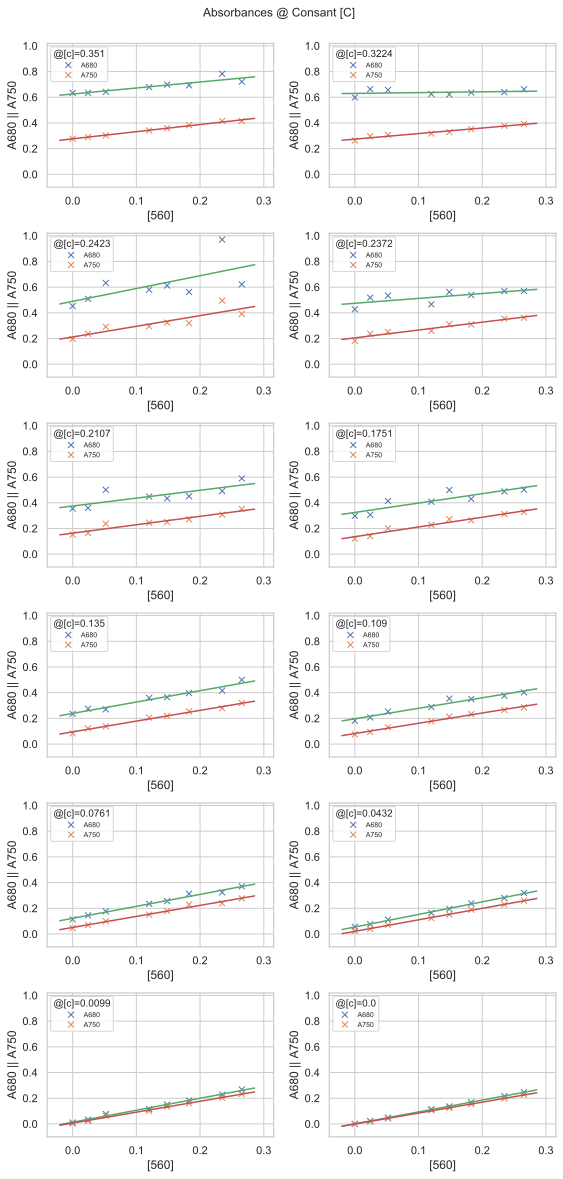

In [29]:
plot_col_rows(df_main, kParams=(kB_A680, kB_A750), plate_row_or_col='col')

In [35]:
#plot_col_rows(tmp, kParams=(kC_A680, kC_A750), plate_row_or_col='row')

In [36]:
kcs = [kB_A680, kB_A750, kC_A680, kC_A750]
for kc in kcs:
    np.mean(kc, axis=0)[0]

0.7264630872842242

0.7442577497657852

1.6858816707251114

0.7145917862452056

In [37]:

    
# Observations:

# as expected the contribution to the A680 signal from the bacteria
# is minimal, this is evidenced by the fact that those absorbance readings
# remain very similar even as the [bacter] changes significantly
# ---its a good way to measure chlamy growth for sure

# Unfortunately there is still chlamy contribution to the A750 signal as
# these are not as steady as we had expected. Note that for each plot here 
# [bacter] is held constant and we're hoping to measure mostly [bacter] at 
# 750 then those measurements should be fairly parallel, but they increase
# with incrasing [chlamy] in every plot

# Fortunately, the slope of the A750 measurement seems to be very constant
# across the board, meaning that there is a certain amount of contribution
# that increasing [chlamy] has on that signal

# ---------------------------M = slope of curve---------------------------
#
# plot: 750_Mi v. [bacter]
# plot: 680_Mi v. [bacter]
#
# - I expect that the each plot's slope for a given wavelen
# - is equivalent to all others M1=M2=...=Mn


# ---------------------------A = area between curves----------------------
# plot: Ai v. [bacter]  | Ai = A_680 - A_750
#
# - I expect that the areas are also all equivalent A1=A2=...=Mn
# ------------------------------------------------------------------------

## Fluorescence
#### 96-W.Plates | Rows

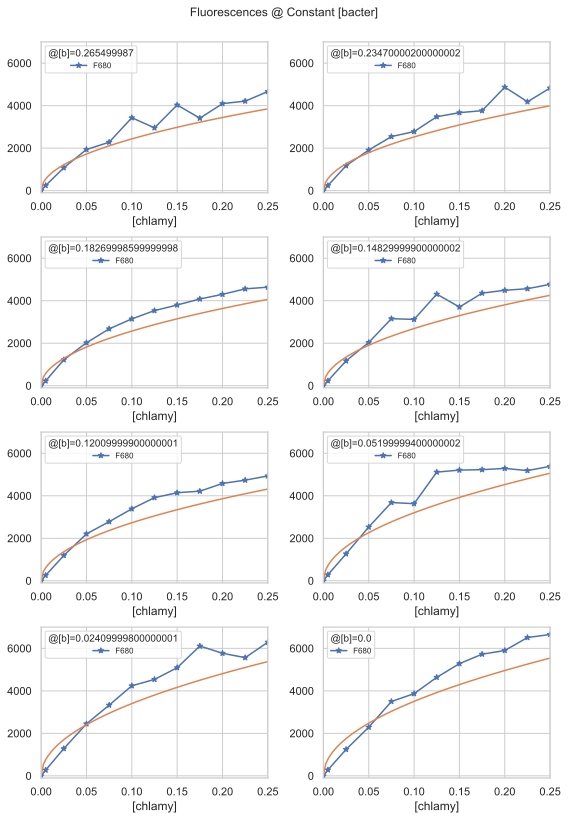

In [40]:
# Note: row=='H' has only Chlamy in the well and no bacteria
plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(4,2)
axes = []
for r in [0,1,2,3]:
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))
        
bacter_cnt_lst = df_main['B'].unique()

# as a generator
axes = (ax for ax in axes)

#x-values for the fitted line
xmock = np.linspace(0, .25, 100)
rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
i = 0
for row in rows:

    ax = next(axes)
    
    df_main.loc[df_main['row']==row].plot(x='C_lbl', y='F680',
                                           style='-*', ax=ax)
    ax.plot(xmock, root_curve(kC_F680[i], xmock))
    ax.set_ylim(-100, 7000)
    ax.set_xlabel('[chlamy]')
    
    ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i]), prop={'size': 8})
    i+=1
    
plt.tight_layout()
plt.suptitle('Fluorescences @ Constant [bacter]', y=1.03);
#plt.savefig('Fluorescence_B.pdf')

#xmock = np.linspace(0, .25, 25)
#for ab in param_a_b_F680:
    #ax = next(axes_)
    #ax.plot(xmock, root_curve(ab,xmock))
    
# Observations:

# there is an obvious exponential relationship between F680 v. [chlamy], and its
# also obvious that the signal is dampened by the increasing [bacter], this means
# that bacteria absorb some of the emitted F680 light... we can try and determine
# how much light is captured by bacteria by plotting the following: 

# ---------------------------A = area under curves----------------------
# plot: Ai v. [bacter] 
# - I expect that the areas show this (-)linear dependency
# ------------------------------------------------------------------------

#### 96-W.Plates | Cols

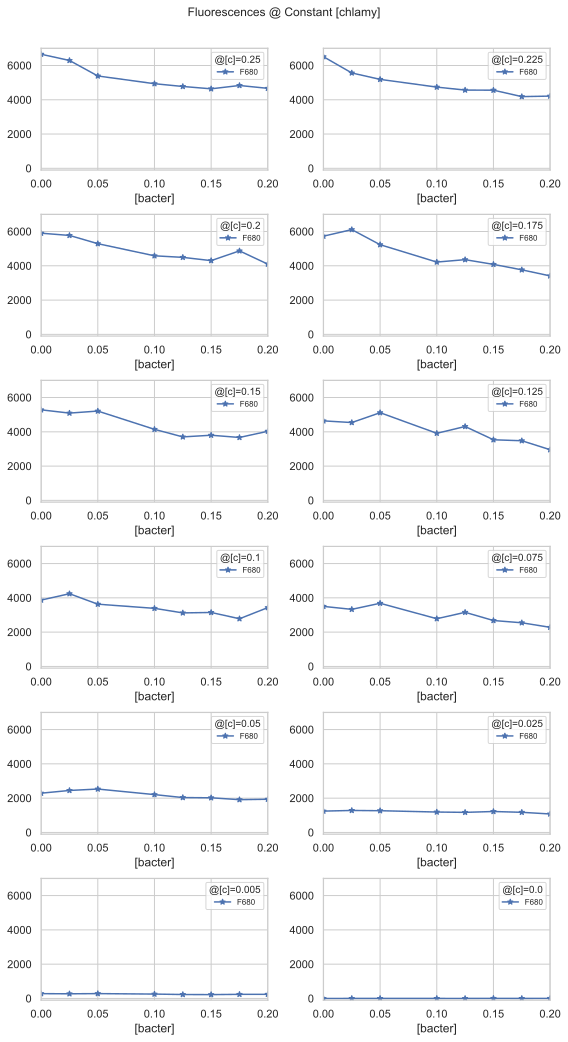

In [41]:
# Note: col='12' has only Bacteria in the well and no chlamy
plt.figure(figsize=(8,14))
gs = gridspec.GridSpec(6,2)
axes = []
for r in range(0,6):
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))        

# axes as a generator
axes = (ax for ax in axes)

i=0
chlamy_cnt_lst = df_main['C_lbl'].unique()
cols=df_main['col'].unique()
for col in cols:
    
    ax=next(axes)

    df_main.loc[df_main['col']==col].plot(x='B_lbl', y='F680',
                                           style='-*', ax=ax)
    #ax.plot(xmock, root_curve(kB_F680[i], xmock))
    
    ax.set_ylim(-100,7000)
    ax.set_xlabel('[bacter]')
    ax.legend(loc=0, title='@'+'[c]='+str(chlamy_cnt_lst[i]), prop={'size': 8})
    i+=1
plt.tight_layout()
plt.suptitle('Fluorescences @ Constant [chlamy]', y=1.03);
#plt.savefig('Fluorescence_C.pdf')

# Observations:

# as the [bacter] increases the fluorescence signal tends to decrease
# likely due to the bacteria absorbing F680

# this plot doesn't strike as being very useful, much like the Column's A680
# measurements

# Parameters

array([0.62527887, 0.62984558, 0.48959304, 0.47448444, 0.37460467,
       0.32460837, 0.23861097, 0.19677401, 0.12216008, 0.05435563,
       0.01330023, 0.00099437])

array([ 0.2763689 ,  0.2740791 ,  0.21231708,  0.20533056,  0.16355744,
        0.13589071,  0.09508223,  0.08201519,  0.05085148,  0.02067589,
        0.00634847, -0.0009176 ])

array([0.35099999, 0.32240001, 0.24230001, 0.2372    , 0.21070001,
       0.17510001, 0.135     , 0.10900001, 0.0761    , 0.04319999,
       0.0099    , 0.        ])

[array([1.33331565, 0.26859448]),
 array([1.69478506, 0.21177004]),
 array([1.4621256 , 0.18045517]),
 array([1.629989, 0.147352]),
 array([1.65292632, 0.11023084]),
 array([1.92861799, 0.05247293]),
 array([1.92165212, 0.00649944]),
 array([ 1.86364163, -0.01675803])]

[array([0.53843781, 0.2345634 ]),
 array([0.68054391, 0.19796401]),
 array([0.61244342, 0.16228079]),
 array([0.681345  , 0.13033638]),
 array([0.70208324, 0.10064059]),
 array([0.82832715, 0.04596011]),
 array([0.85107099, 0.00898645]),
 array([ 0.82248275, -0.0125004 ])]

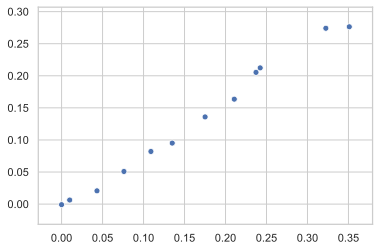

In [28]:
np.array(kB_A680).reshape(12,2)[:,1]

ba750 = np.array(kB_A750).reshape(12,2)[:,1]
ba750
chlamy_cnt
sns.scatterplot(y= ba750, x=chlamy_cnt)

kC_A680
kC_A750

In [24]:
tdf = df_main.copy()

In [25]:
tdf.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.4148,0.4122,0.4095,0.4067,0.4043,0.4019,0.3995,0.3977,0.3955,0.3937
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.4158,0.4129,0.4099,0.4070,0.4041,0.4014,0.3989,0.3967,0.3943,0.3923
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.3793,0.3768,0.3741,0.3710,0.3688,0.3665,0.3642,0.3622,0.3600,0.3582
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.3473,0.3447,0.3418,0.3389,0.3366,0.3342,0.3319,0.3299,0.3277,0.3258
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.3319,0.3293,0.3266,0.3236,0.3214,0.3191,0.3168,0.3146,0.3124,0.3105


In [31]:
f = get_row_col_values(tdf, 'row', 'F680')[0]
a = get_row_col_values(tdf, 'row', 'A680')[0]

#get_row_col_values(tdf, 'col', 'F680')


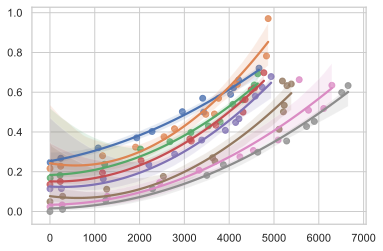

In [48]:
for a, f in zip(get_row_col_values(tdf, 'row', 'A680'), get_row_col_values(tdf, 'row', 'F680')):
    sns.regplot(f, a, order=2, truncate=True)
    #plt.show()

In [43]:
tdf[tdf['row']=='H']

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
H1,H,1,0.0,0.250,6654.0,0.6334,0.2772,0.6029,0.6017,0.6053,...,0.2625,0.2602,0.2579,0.2553,0.2535,0.2516,0.2497,0.2480,0.2462,0.2448
H2,H,2,0.0,0.225,6511.0,0.5985,0.2632,0.5698,0.5682,0.5715,...,0.2410,0.2390,0.2367,0.2343,0.2324,0.2307,0.2289,0.2275,0.2258,0.2243
H3,H,3,0.0,0.200,5901.0,0.4526,0.1970,0.4354,0.4334,0.4341,...,0.1826,0.1808,0.1791,0.1774,0.1756,0.1741,0.1725,0.1710,0.1695,0.1682
H4,H,4,0.0,0.175,5727.0,0.4275,0.1821,0.4163,0.4147,0.4148,...,0.1746,0.1728,0.1710,0.1693,0.1676,0.1664,0.1649,0.1638,0.1625,0.1614
H5,H,5,0.0,0.150,5282.0,0.3544,0.1530,0.3540,0.3534,0.3557,...,0.1577,0.1565,0.1551,0.1538,0.1525,0.1516,0.1505,0.1496,0.1485,0.1476
H6,H,6,0.0,0.125,4638.0,0.2981,0.1203,0.3115,0.3101,0.3105,...,0.1258,0.1247,0.1235,0.1222,0.1210,0.1200,0.1191,0.1183,0.1173,0.1165
H7,H,7,0.0,0.100,3870.0,0.2353,0.0833,0.2492,0.2477,0.2478,...,0.0959,0.0949,0.0937,0.0926,0.0915,0.0908,0.0899,0.0892,0.0883,0.0875
H8,H,8,0.0,0.075,3501.0,0.1817,0.0756,0.2032,0.2014,0.2007,...,0.0772,0.0764,0.0753,0.0743,0.0734,0.0727,0.0720,0.0714,0.0707,0.0702
H9,H,9,0.0,0.050,2289.0,0.1138,0.0460,0.1281,0.1285,0.1294,...,0.0567,0.0563,0.0556,0.0550,0.0544,0.0541,0.0536,0.0532,0.0527,0.0524
